## Jose R F Junior
Data Scientist - web2aajax@gmaail.com


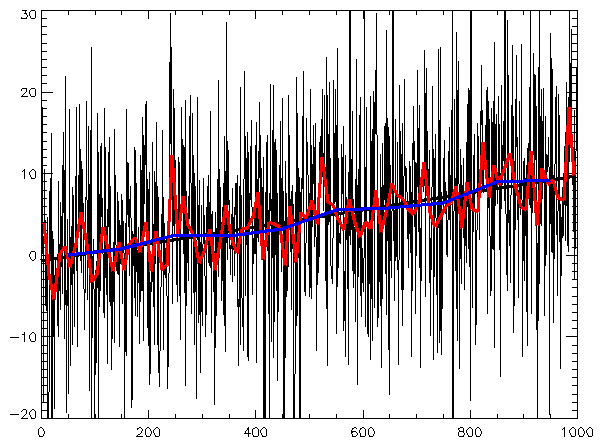

TensorFlow


In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [0]:
import tensorflow as tf
print(tf.__version__)


2.2.0-rc3


O próximo bloco de código configurará a série temporal com sazonalidade, tendência e um pouco de ruído.

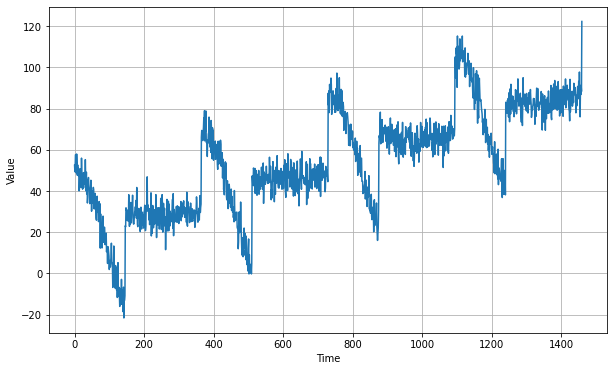

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Tempo")
    plt.ylabel("Valor")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Apenas um padrão arbitrário, você pode alterá-lo se desejar"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
 "" "Repete o mesmo padrão em cada período" ""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Agora que temos a série temporal, vamos dividi-la para que possamos começar a prever

In [0]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

# Naive Forecast

In [0]:
naive_forecast = series[split_time - 1:-1]

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

Vamos ampliar o início do período de validação:

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

Você pode ver que a previsão ingênua fica 1 passo atrás da série cronológica.

Agora vamos calcular o erro médio quadrático e o erro absoluto médio entre as previsões e as previsões no período de validação:

In [0]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

Essa é a nossa linha de base, agora vamos tentar uma média móvel:

In [0]:
def moving_average_forecast(series, window_size):
"" "Prevê a média dos últimos valores. Se window_size = 1, isso é equivalente à previsão ingênua """
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

In [0]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [0]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

Isso é pior do que uma previsão ingênua! A média móvel não antecipa tendência ou sazonalidade, então vamos tentar removê-las usando diferenciação. Como o período de sazonalidade é de 365 dias, subtrairemos o valor no tempo * t * - 365 do valor no tempo * t *.

In [0]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

Ótimo, a tendência e a sazonalidade parecem ter desaparecido, então agora podemos usar a média móvel:

In [0]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

Agora, vamos trazer de volta a tendência e a sazonalidade adicionando os valores passados de t - 365:

In [0]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [0]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

Melhor do que previsão ingênua, bom. No entanto, as previsões parecem um pouco aleatórias, porque estamos apenas adicionando valores passados, que eram barulhentos. Vamos usar uma média móvel dos valores passados para remover parte do ruído:

In [0]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [0]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())